<a href="https://colab.research.google.com/github/mvenouziou/Project-Generative_Model/blob/main/Course_3_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Probabilistic generative models**

**Mo Venouziou's Capstone project for Imperial College London's course 'Probabilistic Deep Learning with TensorFlow 2' on Coursera.**

This notebook constructs generative models using normalising flow networks and the variational autoencoder algorithm.  We create a synthetic dataset with a normalising flow with randomised parameters. This dataset is then used to train a variational autoencoder, with encoder compressing the data into vectors in R2, and decoder to generate new images from the learned distributions.

**IMPORTANT NOTE:**

*The project instructions provided an outline for how to create the autoencoder. It also provided some helper functions for visualizing the data. These are specifically noted within the notebook.*

Global Paramaters

In [31]:
BATCH_SIZE = 20

Imports

In [29]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

# data management
import numpy as np
import pandas as pd

# graphing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# file management
import os
import bz2
import _pickle as cPickle

Google Drive integration for saving/loading model and datasets

In [30]:
from google.colab import drive
directory='/content/gdrive'
drive.mount(directory)
os.chdir('/content/gdrive/MyDrive/Colab_Notebooks/models/autoencoder')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##**1. The normalising flow**

**Base Distribution**

Instructions: Create a Gaussian random variable 𝑧=(𝑧1,𝑧2), which has mean 0 and covariance matrix Σ=𝜎2𝐈2, with 𝜎=0.3.

In [32]:
base_dist = tfp.distributions.MultivariateNormalDiag(
                    loc=[0, 0], scale_diag=[.3, .3])

**Bijector Chain.**

Instructions:  

The complete normalising flow is given by the following chain of transformations:

- 𝑓1(𝑧)=(𝑧1,𝑧2−2)
- 𝑓2(𝑧)=(𝑧1,𝑧22)
- 𝑓3(𝑧)=(𝑧1,𝑧2+𝑎𝑧21)
- 𝑓4(𝑧)=𝑅𝑧, where 𝑅 is a rotation matrix with angle 𝜃
- 𝑓5(𝑧)=tanh(𝑧), where the tanh function is applied elementwise.*

Use or construct bijectors for each of the transformations 𝑓𝑖, 𝑖=1,…,5, and use tfb.Chain and tfb.TransformedDistribution to construct the final transformed distribution.

Ensure to implement the log_det_jacobian methods for any subclassed bijectors that you write.

In [34]:
def f1_shift(shift_amount=[0,-2]):
    return tfb.Shift(shift=shift_amount)

def f2_vert_scale(scale_factor=[1, .5]):
    return tfb.Scale(scale=scale_factor)

class f3_vert_scaled_shift(tfb.Bijector):
    def __init__(self, scale_factor, **kwargs):
        super().__init__(validate_args=False, 
                         forward_min_event_ndims=0,
                         inverse_min_event_ndims=0, 
                         is_constant_jacobian=True)
        self.scale_factor = tf.cast(scale_factor, dtype=tf.float32)

    def _forward(self, x):
        x = tf.cast(x, tf.float32)
        mask = [1,0]
        mask = tfb.Scale(scale=mask)
        pow = tfb.Permute([1,0])(tfb.Power(2)(mask))
        return x + pow.forward(x)

    def _inverse(self, y):
        mask = [1,0]
        mask = tfb.Scale(scale=mask)
        pow = tfb.Permute([1,0])(tfb.Power(2)(mask))
        return y - pow.forward(y)

    def _forward_log_det_jacobian(self, x):
        # df0dx[0] = 1, df0dx[1] = 0, df1dx[0] = 2*scale*x[0], df1dx[1] = 1
        # det = 1*1 - 0*1 = 1, log det = 0
        return tf.constant(0, tf.float32)

class f4_rotation(tfb.Bijector):
    def __init__(self, radians, **kwargs):
        super().__init__(validate_args=False, 
                         forward_min_event_ndims=0,
                         inverse_min_event_ndims=0, 
                         is_constant_jacobian=True)

        radians = tf.cast(radians, tf.float32)
        
        # rotation represented as matrix
        matrix = tf.linalg.LinearOperatorFullMatrix(
                    [[tf.math.cos(radians), -tf.math.sin(radians)],
                     [tf.math.sin(radians), tf.math.cos(radians)]],
                    is_non_singular=True, is_square=True)
        
        # save as bijector
        self.operator = tfb.AffineLinearOperator(shift=0, scale=matrix)

    def _forward(self, x):
        return self.operator.forward(x)
    def _inverse(self, y):
        return self.operator.inverse(y)
    def _forward_log_det_jacobian(self, x):
        # det = cos(t)**2 + sin(t)**2 = 1
        return tf.constant(0, tf.float32)


def f5_activation():
    return tfp.bijectors.Tanh()

In [35]:
def bijector_chain(a, theta):
    """ note: forward range for each coordinateis in (-1,1)
    note: forward domain = R2 """
    return tfb.Chain([f5_activation(), 
                      f4_rotation(radians=theta), 
                      f3_vert_scaled_shift(scale_factor=a),
                      f2_vert_scale(), 
                      f1_shift()])

**Build a Normalizing Flow to transform the 2-D Gaussian random variable 𝑧=(𝑧1,𝑧2), which has mean 0 and covariance matrix Σ=𝜎2𝐈2, with 𝜎=0.3
.**

In [36]:
def transformed_dist(a, theta, 
                     base_dist=base_dist, bijector_chain=bijector_chain):

    """ 
    Creates a new distribution object by applying bijectors 
    to a base distribution
    Paramaters: theta∼U[0,2π), a∼N(3,1)"""

    return tfd.TransformedDistribution(distribution=base_dist, 
                                       bijector=bijector_chain(a, theta))

**Display a scatter plot of samples from the base distribution.**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


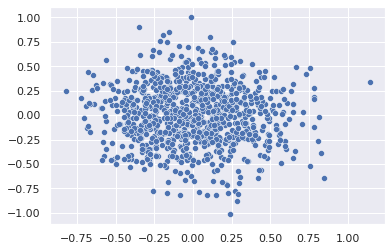

In [37]:
num_samples = 1000
sample = base_dist.sample(num_samples)
sns.scatterplot(sample[:,0], sample[:,1])

**Display 4 scatter plot images of the transformed distribution from your random normalising flow, using samples of θ and a. Fix the axes of these 4 plots to the range [−1,1].**

<Figure size 360x360 with 0 Axes>

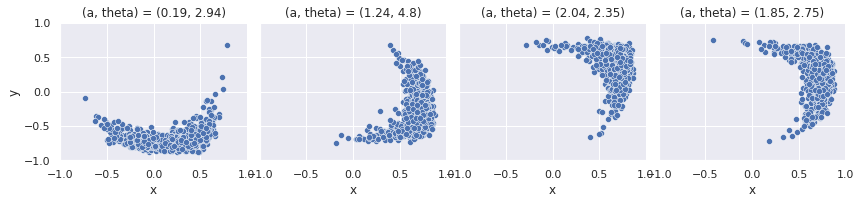

In [38]:
def plot_distribution(distribution=transformed_dist, num_plots=4, num_samples=1000):

    # select paramaters from appropriate distributions
    theta = tfd.Uniform(0, 2*np.pi).sample(num_plots)
    a = tfd.Normal(3,1).sample(num_plots)

    # initialize container for graphing data
    df = pd.DataFrame(columns=['x', 'y', '(a, theta)'])

    # add datapoints from each paramaterization
    for i in range(num_plots):

        # get params
        theta_i = theta[i].numpy()
        a_i = a[i].numpy()

        # convert params to tuple (for indexing)
        param_pairs = [theta_i, a_i] * np.ones((num_samples,2))
        param_pairs = np.around(param_pairs ,2)  # show rounded values in label
        param_pairs = zip(param_pairs[:,0], param_pairs[:,1])

        # get sample data via transformation
        trans_sample = distribution(a_i, theta_i).sample(num_samples)

        # update DataFrame
        new_df = pd.DataFrame({'x': trans_sample[:,0], 
                               'y': trans_sample[:,1], 
                               '(a, theta)': param_pairs})
        df = pd.concat([df, new_df])

    # create plot
    sns.set_theme(), plt.figure(figsize=(5, 5))  # display settings
    plot = sns.FacetGrid(df, col='(a, theta)')  # multiple plot display
    plot = plot.map(sns.scatterplot, 'x', 'y')  # scatter plot
    plot.set(xlim=(-1,1)), plot.set(ylim=(-1,1))  # axis
    plot


plot_distribution()

## **2. Create the image dataset**

**Helper functions to compute transformed distribution densities.**

*NOTE: these two functions are minor adaptations of functions provided in the project instructions*

In [39]:
# Helper function to compute transformed distribution densities
# NOTE: This function was provided in the project instructions, with minor adaptations
def get_densities(transformed_distribution, ticks_per_axis=100):
    """
    This function takes a (batched) Distribution object as an argument, and returns a numpy 
    array Z of shape (batch_shape, 100, 100) of density values, that can be used to make a 
    contour plot with:
    plt.contourf(X, Y, Z[b, ...], cmap='hot', levels=100)
    where b is an index into the batch shape.
    """

    # create input grid
    x = tf.linspace(-1., 1., ticks_per_axis)
    y = tf.linspace(-1., 1., ticks_per_axis)
    grid = tf.meshgrid(x, y)
    grid = tf.transpose(grid, [1,2,0])  # shape (ticks, ticks, 2)

    # update dims to broadcast against dist batch_shape=[], event_shape=2
    grid = tf.expand_dims(grid, axis=-2)  # shape (ticks, ticks, 1, 2)
    grid = tf.cast(grid, tf.float32)

    # compute probs
    Z = transformed_distribution.prob(grid)

    return Z, tf.squeeze(grid)


# Helper function to convert contour plots to numpy arrays
# NOTE: This function was provided in the project instructions, with minor adaptations
def get_image_array_from_density_values(Z, grid):
    """
    This function takes a numpy array Z of density values of shape (100, 100)
    and returns an integer numpy array of shape (36, 36, 3) of pixel values for an image.
    """

    from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
    from matplotlib.figure import Figure

    # set up plot area
    fig = Figure(figsize=(0.5, 0.5))
    canvas = FigureCanvas(fig)
    ax = fig.gca()
    ax.axis('off')
    fig.tight_layout(pad=0)
    ax.margins(0)

    # plot contours
    ax.contourf(grid[:,:,0], grid[:,:,1], Z, cmap='hot', levels=100)
    fig.canvas.draw()

    # save image to buffer
    image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), 
                                    dtype=np.uint8)
    
    # convert to array
    image_from_plot = image_from_plot.reshape(
        fig.canvas.get_width_height()[::-1] + (3,))

    return image_from_plot

**Display a sample of 4 contour plot images from your normalising flow network using 4 independently sampled sets of parameters.**

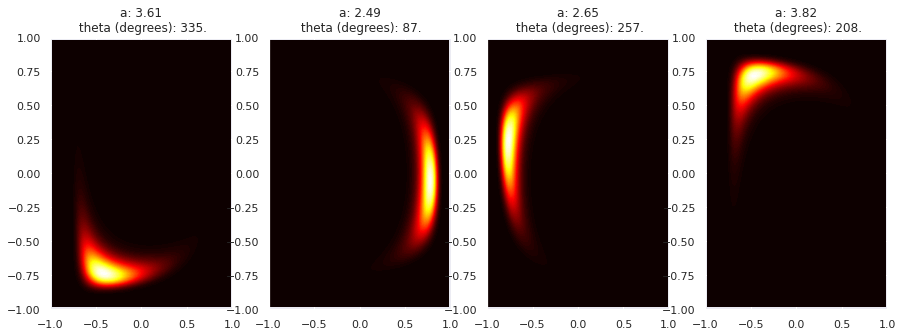

In [40]:
def get_contours(distribution=transformed_dist, num_plots=4, create_plot=True):

    # initialize graph
    ticks_per_axis=100
    if create_plot:   
        fig, axs = plt.subplots(1, num_plots, figsize=(15, 5))

    # initialize container
    Z_all = np.zeros((ticks_per_axis, ticks_per_axis, num_plots))

    # select paramaters for each of the plots
    theta = tfd.Uniform(0, 2*np.pi).sample(num_plots)
    a = tfd.Normal(3,1).sample(num_plots)

    # add datapoints from each paramaterization
    for i in range(num_plots):

        # get params
        theta_i = theta[i].numpy()
        a_i = a[i].numpy()

        # get densities
        Z, grid = get_densities(distribution(a_i, theta_i), 
                                ticks_per_axis=ticks_per_axis)
        
        Z_all[:,:,i] = Z[:,:,0].numpy()

    # create contours 
    if create_plot:  
        for i in range(num_plots):
            axs[i].contourf(grid[:,:,0], grid[:,:,1], Z_all[:,:,i], 
                            cmap='hot', levels=100)
            axs[i].set_title(f'a: {np.format_float_positional(a[i], 2)}\n ' +    
                                f'theta (degrees): {np.format_float_positional(theta[i] * 180/np.pi, 0)}')
        plt.show()

    return Z_all


_ = get_contours(num_plots=4, create_plot=True)

**Create Dataset**

*Your dataset should consist of at least 1000 images, stored in a numpy array of shape (N, 36, 36, 3). Each image in the dataset should correspond to a contour plot of a transformed distribution from a normalising flow with an independently sampled set of parameters.*

In [41]:
def create_dataset(num_samples):

    # initialize container
    rgb_arrays = np.zeros((num_samples, 36, 36, 3))

    # create grid
    _, grid = get_densities(transformed_dist(0,3))  # note: the params used here aren't used

    # get densities
    Z = get_contours(distribution=transformed_dist,
                     num_plots=num_samples, create_plot=False)

    # convert to 3d image array
    for i in range(num_samples):
        rgb_arrays[i, :, : ,:] = get_image_array_from_density_values(Z[:,:,i], grid)

    return rgb_arrays

In [42]:
# Generate images for display.
# Since these take a while to process I have created this code 
# to save/load previosuly created datasets

# check for saved datafile 
if os.path.isfile('datasets/x_train.pbz2'):
    with bz2.open('datasets/x_train.pbz2', 'rb') as file:
        x_train = cPickle.load(file)
    print('loaded saved dataset')

    get_additional_data = False
    # add a few more data samples
    if get_additional_data:
        num_new_samples = 1000
        x_train_new = create_dataset(num_new_samples)
        x_train = x_train = np.concatenate([x_train, x_train_new], axis=0)

        # save data to disk (pbz2 compressed file format)
        with bz2.BZ2File('datasets/x_train.pbz2', 'wb') as sfile:
            cPickle.dump(x_train, sfile)

else:
    # create fresh dataset
    x_train = create_dataset(1000)
    print('generated new dataset')

    # save data to disk (pbz2 compressed file format)
    with bz2.BZ2File('datasets/x_train.pbz2', 'wb') as sfile:
        cPickle.dump(x_train, sfile)

print(x_train.shape)
print('Num samples:', x_train.shape[0])

loaded saved dataset
(5000, 36, 36, 3)
Num samples: 5000


**Display a sample of 20 images from your generated dataset in a figure.**

In [43]:
# select images

def display_generated_images(num_images, images_array=x_train, num_columns=5):
    indices = np.random.choice(x_train.shape[0], size=num_images, replace=False)

    num_rows = num_images//num_columns
    if num_images%num_columns !=0:
        num_rows = num_rows + 1
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(10,10))

    for i, pic_indx in zip(range(num_images), indices):

        # select image and rescale rgb to (0,1)
        picture = x_train[pic_indx, :, :, :] / 255.  
        axs[i//num_columns, i%num_columns ].imshow(picture)

    plt.show()

    return None

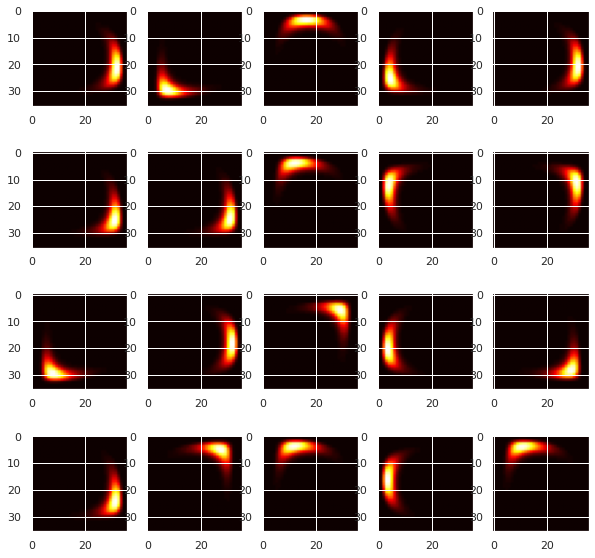

In [44]:
display_generated_images(20)

## **3. Make `tf.data.Dataset` objects**

Instructions:

- Split your dataset to create tf.data.Dataset objects for training and validation data.
- Using the map method, normalise the pixel values so that they lie between 0 and 1.
- These Datasets will be used to train a variational autoencoder (VAE). Use the map method to return a tuple of input and output Tensors where the image is duplicated as both input and output.
- Randomly shuffle the training Dataset.
- Batch both datasets with a batch size of 20, setting drop_remainder=True.

**Convert samples to TF Datasets**

In [45]:
def prepare_vae_dataset(x_train, test_split=.2, verbose=True):

    num_test_samples = int(test_split * x_train.shape[0])
    ds = tf.data.Dataset.from_tensor_slices(x_train)

    # normalize values
    ds = ds.map(lambda x: tf.cast(x, tf.float32)/255.)

    # create input/target pairs
    ds = ds.map(lambda x: [x, x])

    # shuffle
    ds = ds.shuffle(2000)
    
    # test/ train split
    test_ds = ds.take(num_test_samples)
    train_ds = ds.skip(num_test_samples)

    # create batches
    train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

    if verbose:
        print('Element Spec:')
        print(train_ds.element_spec)

    return test_ds, train_ds

In [68]:
test_ds, train_ds = prepare_vae_dataset(x_train, verbose=False)

**Print the element_spec property for one of the Dataset objects.**

In [67]:
test_ds.element_spec

(TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(20, 36, 36, 3), dtype=tf.float32, name=None))

## **4. Build the encoder and decoder networks**

Instructions:

- Create the encoder and decoder for the variational autoencoder algorithm.

- You should design these networks yourself, subject to the following constraints:
   * The encoder and decoder networks should be built using the `Sequential` class.
   * The encoder and decoder networks should use probabilistic layers where necessary to represent distributions.
   * The prior distribution should be a zero-mean, isotropic Gaussian (identity covariance matrix).
   * The encoder network should add the KL divergence loss to the model.

**Create Encoder**

In [47]:
import tensorflow_probability as tfp
tfpl = tfp.layers
tfd = tfp.distributions


def create_encoder(encoded_size=2, verbose=True):
    from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, \
                                        UpSampling2D, Reshape, Dense, \
                                        Activation, MaxPool2D, Flatten

    from tensorflow.keras.activations import relu

    # customize activation function
    leaky_relu = lambda x: tf.keras.activations.relu(x, alpha=.1)
    tanh = 'tanh'

    # Prior / posterior distributions for variational layer
    prior = tfd.MultivariateNormalDiag(loc=tf.zeros(encoded_size),
                                       scale_diag=tf.ones(encoded_size))
        
    regularizer = tfpl.KLDivergenceRegularizer(
                    distribution_b=prior, 
                    use_exact_kl=False, 
                    test_points_reduce_axis=None,
                    test_points_fn=lambda dist: dist.sample(3), 
                    weight=1.0
                    )

    # encoder network
    encoder = tf.keras.Sequential(name='encoder', layers=[
                    Input(shape=(36,36,3)),
                    
                    # Feature extractions (Conv2D blocks)
                    Conv2D(filters=32, kernel_size=4, 
                        strides=2, padding='same', activation=leaky_relu),
                    BatchNormalization(),
                    Conv2D(filters=64, kernel_size=4, 
                            strides=2, padding='same', activation=leaky_relu),
                    BatchNormalization(),                    
                    Conv2D(filters=128, kernel_size=4, 
                            strides=2, padding='same',activation=leaky_relu),
                    BatchNormalization(),                    
                    Conv2D(filters=256, kernel_size=2, 
                            strides=2, padding='same', activation=leaky_relu),
                    BatchNormalization(),
                    Conv2D(filters=512, kernel_size=2, 
                            strides=2, padding='valid', activation=leaky_relu),
                    
                    # Dense layers
                    Flatten(),
                    Dense(units=256, activation='tanh', kernel_regularizer='l2'), 
                    Dense(units=tfpl.MultivariateNormalTriL.params_size(encoded_size),
                          activation=None), 
                    
                    # variational block
                    tfpl.MultivariateNormalTriL(encoded_size,
                                        activity_regularizer=regularizer),
            ])
   
    if verbose:
        encoder.summary()
    
    return encoder

In [48]:
create_encoder(verbose=True)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 18, 18, 32)        1568      
_________________________________________________________________
batch_normalization_8 (Batch (None, 18, 18, 32)        128       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 9, 9, 64)          32832     
_________________________________________________________________
batch_normalization_9 (Batch (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 5, 5, 128)         131200    
_________________________________________________________________
batch_normalization_10 (Batc (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 3, 3, 256)         1313

**Create Decoder**

In [49]:
def create_decoder(encoded_size=2, verbose=True):

    from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, \
                            UpSampling2D, Reshape, Dense, Activation, \
                            Conv2DTranspose, Flatten

    from tensorflow.keras.activations import relu
    leaky_relu = lambda x: tf.keras.activations.relu(x, alpha=0.1)

    # decoder network
    decoder = tf.keras.Sequential(name='decoder', layers=[
                    Input(shape=(encoded_size)),    

                    # Dense layers
                    Dense(16*256, activation=leaky_relu, kernel_regularizer='l2'),

                    # Feature recreations (Conv2D blocks)
                    Reshape((4, 4, 256)),

                    Conv2DTranspose(filters=128, kernel_size=3, 
                            strides=3, activation=leaky_relu),
                    #UpSampling2D(3),

                    Conv2DTranspose(filters=64, kernel_size=3, 
                            strides=3, activation=leaky_relu),
                    #UpSampling2D(3),

                    Conv2DTranspose(filters=32, kernel_size=3, 
                            strides=2, activation=leaky_relu),
                    
                    Conv2D(3, kernel_size=3, strides=2),
                    
                    # distribution output
                    Flatten(),
                    tfp.layers.IndependentBernoulli(event_shape=(36,36,3)),
    ])
    
    if verbose:
        decoder.summary()

    return decoder

In [50]:
create_decoder(verbose=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 4096)              12288     
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 12, 12, 128)       295040    
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 36, 36, 64)        73792     
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 73, 73, 32)        18464     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 36, 36, 3)         867       
_________________________________________________________________
flatten_5 (Flatten)          (None, 3888)              0   

## **5. Train the variational autoencoder**

Initialize encoder / decoder models

In [51]:
# initialize model
encoded_size = 2
encoder = create_encoder(encoded_size=encoded_size, verbose=False)
decoder = create_decoder(encoded_size=encoded_size, verbose=False)

# get checkpoint managers
encoder_checkpoint_manager = tf.train.CheckpointManager(
    checkpoint=tf.train.Checkpoint(encoder), 
    directory='model_checkpoints/encoder', 
    max_to_keep=4, checkpoint_name='encoder_ckpt')

decoder_checkpoint_manager = tf.train.CheckpointManager(
    checkpoint=tf.train.Checkpoint(decoder), 
    directory='model_checkpoints/decoder', 
    max_to_keep=4, checkpoint_name='decoder_ckpt')

# load latest checkpoints
encoder_checkpoint_manager.restore_or_initialize()
decoder_checkpoint_manager.restore_or_initialize()

**Create VAE Model using the Model class and the encoder and decoder models.**

In [52]:
# create autoencoder
vae_autoencoder = tf.keras.Model(inputs=encoder.inputs, 
                                 outputs=decoder(encoder.outputs),
                                 name='autoencoder')

# load training history
if os.path.isfile('model_checkpoints/autoencoder/training_history.pbz2'):
    with bz2.open('model_checkpoints/autoencoder/training_history.pbz2') as file:
        training_history = cPickle.load(file)
else:
    training_history = {'loss':[], 'val_loss':[]}   

In [53]:
# show model summary
print('Variational Auto Encoder:')
vae_autoencoder.summary()

Variational Auto Encoder:
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 36, 36, 3)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 18, 18, 32)        1568      
_________________________________________________________________
batch_normalization_12 (Batc (None, 18, 18, 32)        128       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 9, 9, 64)          32832     
_________________________________________________________________
batch_normalization_13 (Batc (None, 9, 9, 64)          256       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 5, 5, 128)         131200    
_________________________________________________________________
batch_normalization_14 (Batc 

**Compile the VAE with the negative log likelihood loss and train with the fit method, using the training and validation Datasets.**

Loss Function

In [55]:
# set loss function
def nll(y_true, y_pred):
    return -tf.reduce_mean(y_pred.log_prob(y_true))

Utility for saving checkpoints

In [54]:
def save_checkpoints(encoder_checkpoint_manager, decoder_checkpoint_manager, 
                     training_history):
    
    # model weights
    encoder_checkpoint_manager.save()
    decoder_checkpoint_manager.save()

    # training history
    with bz2.BZ2File('model_checkpoints/autoencoder/training_history.pbz2', 
                     'wb') as sfile:
        cPickle.dump(training_history, sfile)

    return None

Compile & Train Model

In [56]:
train_model = True
learning_rate = 0.00001
num_epochs = 100

if train_model:
    # compile model
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)

    vae_autoencoder.compile(optimizer=optimizer, loss=nll, metrics=None)

    # set callbacks
    callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-2, patience=8)]

    # run training
    history = vae_autoencoder.fit(train_ds, epochs=num_epochs, 
                                  validation_data=test_ds, callbacks=callbacks)

    # update model history across multiple calls to model.fit()
    training_history['loss'] += history.history['loss']
    training_history['val_loss'] += history.history['val_loss']

    # save checkpoints and training history
    save_checkpoints(encoder_checkpoint_manager, decoder_checkpoint_manager, 
                     training_history)

Epoch 1/100
200/200 [==============================] - 4s 12ms/step - loss: 2674.5342 - val_loss: 2608.6829
Epoch 2/100
200/200 [==============================] - 2s 9ms/step - loss: 1944.4853 - val_loss: 1117.8007
Epoch 3/100
200/200 [==============================] - 2s 8ms/step - loss: 817.1196 - val_loss: 729.3369
Epoch 4/100
200/200 [==============================] - 2s 8ms/step - loss: 719.2723 - val_loss: 700.0804
Epoch 5/100
200/200 [==============================] - 2s 9ms/step - loss: 696.2721 - val_loss: 685.6624
Epoch 6/100
200/200 [==============================] - 2s 9ms/step - loss: 682.7010 - val_loss: 674.1856
Epoch 7/100
200/200 [==============================] - 2s 8ms/step - loss: 671.4027 - val_loss: 663.0522
Epoch 8/100
200/200 [==============================] - 2s 9ms/step - loss: 659.8438 - val_loss: 649.7662
Epoch 9/100
200/200 [==============================] - 2s 10ms/step - loss: 645.4158 - val_loss: 631.2750
Epoch 10/100
200/200 [===========================

**Plot the learning curves for loss vs epoch for both training and validation sets.**

In [57]:
def plot_learning_curves(model_history):

    # set up axes
    num_metrics = len(model_history)
    fig, axes = plt.subplots(1, num_metrics, sharey=True, figsize=(10, 10))

    # set shared labels
    fig.suptitle('Learning Curves', fontsize='x-large', fontweight='bold')
    axes[0].set_ylabel('Loss')

    # plot each graph
    for i, metric in zip(range(num_metrics), model_history):
        num_iterations = len(model_history[metric])

        if num_metrics == 1:
            axes.scatter(x=list(range(num_iterations)), 
            y=model_history[metric])
        
        else:
            axes[i].scatter(x=list(range(num_iterations)), 
                            y=model_history[metric])
        
            # subplot labels
            axes[i].set_xlabel('Epoch')
            axes[i].set_title(f'{metric}')
            axes[i].set_xticks(ticks=list(range(num_iterations)))

    plt.show()

    return None

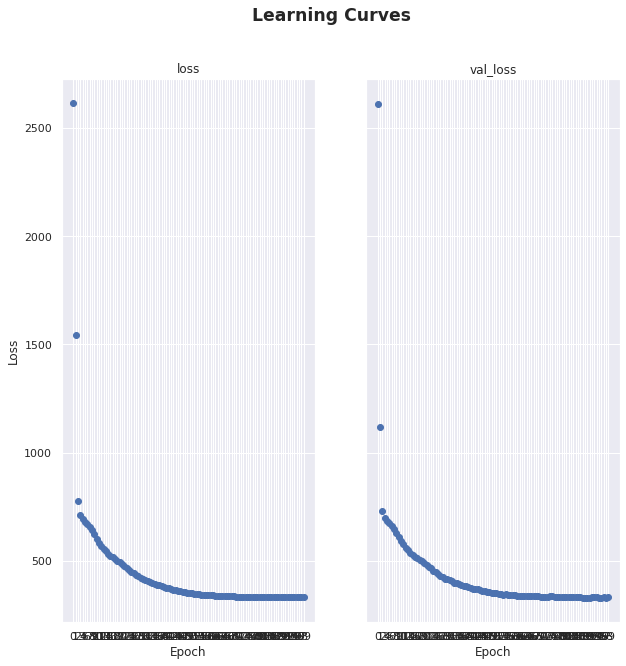

In [58]:
plot_learning_curves(model_history=training_history)

## **6. Use the encoder and decoder networks**
* You can now put your encoder and decoder networks into practice!
* Randomly sample 1000 images from the dataset, and pass them through the encoder. Display the embeddings in a scatter plot (project to 2 dimensions if the latent space has dimension higher than two).
* Randomly sample 4 images from the dataset and for each image, display the original and reconstructed image from the VAE in a figure.
  * Use the mean of the output distribution to display the images.
* Randomly sample 6 latent variable realisations from the prior distribution, and display the images in a figure.
  * Again use the mean of the output distribution to display the images.

**Randomly sample 1000 images from the dataset, and pass them through the encoder.
Display the embeddings in a scatter plot.**

In [59]:
def plot_encodings(encoder, dataset, num_images=1000):
    """ shows a sample of 2D encoding values """

    # collect encoding values
    for x in dataset.unbatch().shuffle(20000).batch(num_images).take(1):
        
        # get inputs as single tensor
        x = x[0]

        # get auto-encoded images
        y = encoder(x)
        y = y.sample(1)  
        y = tf.squeeze(y)

    # create plot
    #plt.scatter(y[:,0], y[:,1])
    #plt.show()
    sns.scatterplot(x=y[:,0], y=y[:,1])

    return plt


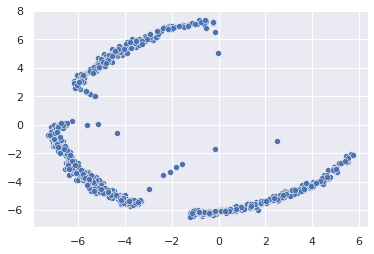

In [60]:
plt = plot_encodings(encoder, dataset=train_ds, num_images=1000)

**Randomly sample 4 images from the dataset and for each image, display the original and reconstructed image from the VAE in a figure.**

Use the mean of the output distribution to display the images.


In [61]:
def display_before_and_after(autoencoder, num_images=4):

    for x in train_ds.unbatch().shuffle(2000).batch(num_images).take(1):
        original = x[0]
        reconstruction = autoencoder(original).mean()
        reconstruction = tf.squeeze(reconstruction)

    fig, axes = plt.subplots(2, num_images, sharex=True, sharey=True,
                             figsize=(10, 5))

    for indx in range(reconstruction.shape[0]):
        axes[0, indx].imshow(original[indx,:,:,:])
        axes[1, indx].imshow(reconstruction[indx,:,:,:])

    # set labels
    axes[0, 0].set_title(f'Original:')
    axes[1, 0].set_title(f'Reconstruction:')

    plt.show()

    return None

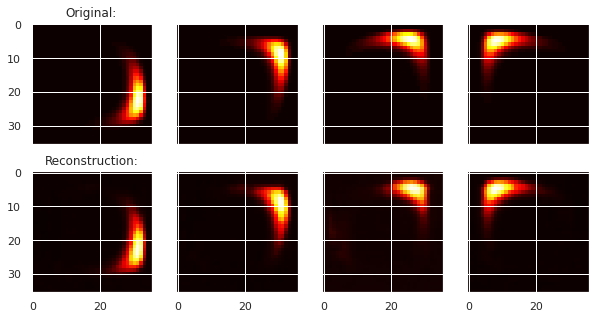

In [62]:
display_before_and_after(autoencoder=vae_autoencoder, num_images=4)

**Randomly sample 6 latent variable realisations from the prior distribution, and display the images in a figure.**

Use the mean of the output distribution to display the images.


In [63]:
def sample_from_prior(encoder, decoder, num_images=6):

    for x in train_ds.unbatch().shuffle(2000).batch(num_images).take(1):
        original = x[0]
        prior_dist = encoder(original)
        latent_variables = prior_dist.sample()

    generated_images = decoder(latent_variables).mean()

    # display images
    num_columns = num_images//2 + num_images%2
    fig, axes = plt.subplots(2, num_columns, sharex=True, sharey=True,
                             figsize=(10, 5))

    for indx in range(generated_images.shape[0]):
        axes[indx//num_columns, indx%num_columns].imshow(
            generated_images[indx,:,:,:])

    plt.show()

    return None

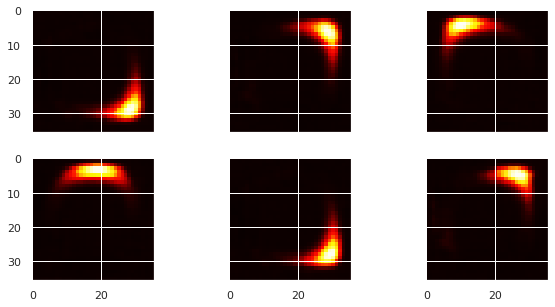

In [64]:
sample_from_prior(encoder, decoder, num_images=6)

*NOTE: THE CODE BELOW WAS PROVIDED IN PROJECT INSTRUCTIONS*

## Make a video of latent space interpolation##

Just for fun, you can run the code below to create a video of your decoder's generations, depending on the latent space.

In [65]:
""" NOTE: this function was provided in the project instructions """

import matplotlib.animation as anim
from IPython.display import HTML

# Function to create animation
def get_animation(latent_size, decoder, interpolation_length=500):
    assert latent_size >= 2, "Latent space must be at least 2-dimensional for plotting"
    
    # set figure options
    fig = plt.figure(figsize=(9, 4))  
    ax1 = fig.add_subplot(1,2,1)
    ax1.set_xlim([-3, 3])
    ax1.set_ylim([-3, 3])
    ax1.set_title("Latent space")
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Data space")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)

    # initializing a line variable 
    line, = ax1.plot([], [], marker='o')
    img2 = ax2.imshow(np.zeros((36, 36, 3)))

    freqs = np.random.uniform(low=0.1, high=0.2, size=(latent_size,))
    phases = np.random.randn(latent_size)
    input_points = np.arange(interpolation_length)
    latent_coords = []
    for i in range(latent_size):
        latent_coords.append(2 * np.sin((freqs[i]*input_points + phases[i])).astype(np.float32))

    def animate(i): 
        z = tf.constant([coord[i] for coord in latent_coords])
        img_out = np.squeeze(decoder(z[np.newaxis, ...]).mean().numpy())
        line.set_data(z.numpy()[0], z.numpy()[1])
        img2.set_data(np.clip(img_out, 0, 1))
        return (line, img2)

    return anim.FuncAnimation(fig, animate, frames=interpolation_length, 
                              repeat=False, blit=True, interval=150)

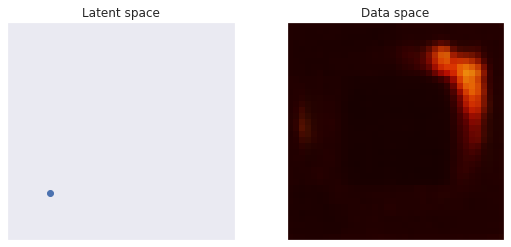

In [66]:
# Create the animation
a = get_animation(latent_size=2, decoder=decoder, interpolation_length=200)
HTML(a.to_html5_video())